<p style="font-family:Georgia; font-size:16px; text-align:right; background-color:Gainsboro;">Arda Hüseyinoğlu, Spring 2022</p> 
<p style="font-family:Times New Roman; font-size:30px; "><b> BBM446 - Computational Photography Laboratory</b></p>
<p style="font-family:Times New Roman; font-size:30px; "><b> Assignment 3 : Flash / No Flash Photography</b></p>
<br>

In [151]:
import os
import numpy as np
import cv2
import skimage
import math
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import interpolate
from skimage import io
from IPython.display import Image
from cp_assgn2 import lRGB2XYZ, XYZ2lRGB
plt.rcParams["figure.figsize"] = (10,6.5)

In [152]:
def plot_img(img,title,x1,x2,y1,y2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax1.imshow(np.clip(img,0,1))
    ax1.axis('off')
    ax1.set_title(title, fontsize=30)
    ax2.imshow(np.clip(img[y1:y2, x1:x2],0,1))
    ax2.axis('off')
    plt.show()

<br>
<p style="font-family:Georgia; font-size:23px"><b>1. Bilateral Filtering </b></p>

In [153]:
def gaussian(x, sigma):
    return (1.0 / (2 * math.pi * (sigma ** 2))) * math.exp(- (x ** 2) / (2 * sigma ** 2))

In [154]:
def apply_bf_to_pixel(img_channel, resulting_img, i, j, kernel_size, sigma_s, sigma_r, jbf, jbf_image):
    W_sum = 0
    weighted_intensity_sum = 0
    start_i = i - kernel_size//2
    start_j = j - kernel_size//2
    
    for m in range(0, kernel_size):
        for n in range(0,kernel_size):
            
            space_distance = np.sqrt(((start_i+m)-i)**2 + ((start_j+n)-j)**2)
            range_distance = 0
            
            if jbf == False:
                range_distance = img_channel[start_i+m][start_j+n] - img_channel[i][j]
            else:
                range_distance = jbf_image[start_i+m][start_j+n] - jbf_image[i][j]
            
            space_weight = gaussian(space_distance, sigma_s)
            range_weight = gaussian(range_distance, sigma_r)
            W_sum += (space_weight * range_weight)
            weighted_intensity_sum += space_weight * range_weight * img_channel[start_i+m][start_j+n]
            
    resulting_img[i][j] = weighted_intensity_sum / W_sum

In [155]:
def bilateral_filter_channel(img_channel, kernel_size, sigma_s, sigma_r, jbf, jbf_image):
    resulting_img = np.zeros(img_channel.shape)
    
    for i in tqdm(range(kernel_size//2, img_channel.shape[0] - kernel_size//2)):
        for j in range(kernel_size//2, img_channel.shape[1] - kernel_size//2):
            apply_bf_to_pixel(img_channel, resulting_img, i, j, kernel_size, sigma_s, sigma_r, jbf, jbf_image)
    
    return resulting_img        

In [156]:
def bilateral_filter_rgb_image(img, kernel_size, sigma_s, sigma_r, jbf=False, jbf_image=None):
    img_r = img[:,:,0]
    img_g = img[:,:,1]
    img_b = img[:,:,2]
    
    jbf_img_r = None
    jbf_img_g = None
    jbf_img_b = None   
    
    if jbf == True:
        jbf_img_r = jbf_image[:,:,0]
        jbf_img_g = jbf_image[:,:,1]
        jbf_img_b = jbf_image[:,:,2]    
    
    img_r_base = bilateral_filter_channel(img_r, kernel_size, sigma_s, sigma_r, jbf, jbf_img_r)
    img_g_base = bilateral_filter_channel(img_g, kernel_size, sigma_s, sigma_r, jbf, jbf_img_g)
    img_b_base = bilateral_filter_channel(img_b, kernel_size, sigma_s, sigma_r, jbf, jbf_img_b)
    
    filtered_img = np.dstack((img_r_base, img_g_base, img_b_base))
    
    return filtered_img

In [160]:
A = io.imread('data\my_images\my_ambient.jpg')
F = io.imread('data\my_images\my_flash.jpg')
#A = io.imread('data\lamp\lamp_ambient.tif')
#F = io.imread('data\lamp\lamp_flash.tif')

In [161]:
A = A / 255
F = F / 255

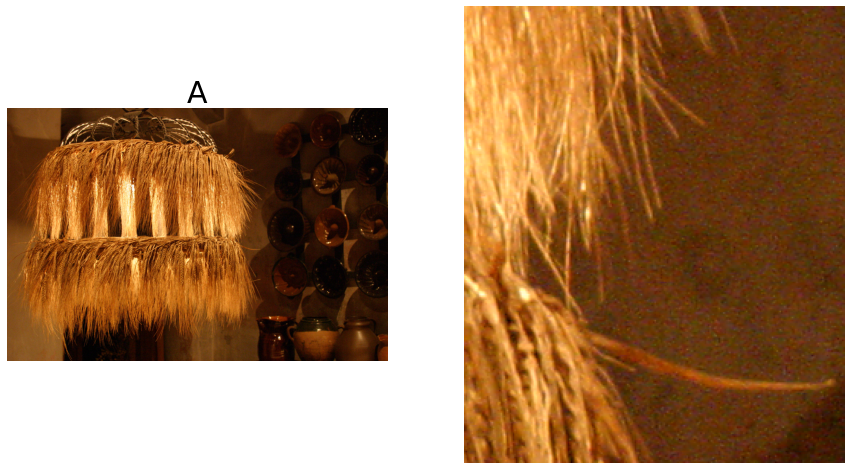

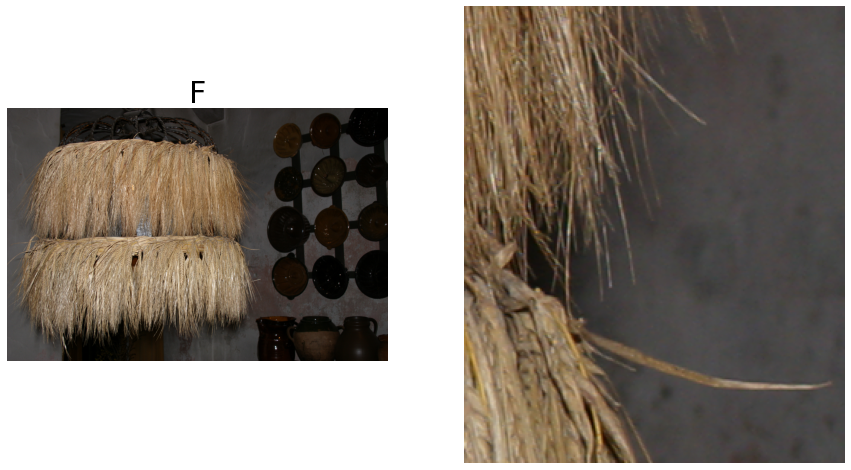

In [107]:
plot_img(A,"A", 1800, 2050, 900, 1200)
plot_img(F,"F", 1800, 2050, 900, 1200)

<br>
<p style="font-family:Georgia; font-size:20px"><b>a. Implement bilateral filtering  </b></p>

In [162]:
A_base = bilateral_filter_rgb_image(A, kernel_size=3, sigma_s=64, sigma_r=0.25)
#A_base_cv2 = cv2.bilateralFilter(A.astype("float32"), 3, 0.25, 64)

100%|██████████████████████████████████████████████████████████████████████████████| 2878/2878 [06:09<00:00,  7.78it/s]


<br>
<p style="font-family:Georgia; font-size:20px"><b>b. Implement joint-bilateral filtering  </b></p>

In [163]:
A_NR = bilateral_filter_rgb_image(A, kernel_size=3, sigma_s=64, sigma_r=0.5, jbf=True, jbf_image=F)

100%|██████████████████████████████████████████████████████████████████████████████| 2878/2878 [06:03<00:00,  7.91it/s]


<br>
<p style="font-family:Georgia; font-size:20px"><b>c. Implement detail transfer   </b></p>

In [164]:
F_base = bilateral_filter_rgb_image(F, kernel_size=3, sigma_s=64, sigma_r=0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 2878/2878 [05:57<00:00,  8.04it/s]


In [165]:
epsilon = 0.02
F_detail = (F + epsilon) / (F_base + epsilon)
A_detail = A_NR * F_detail

<br>
<p style="font-family:Georgia; font-size:20px"><b>d. Implement shadow and specularity masking &#38; Get final image  </b></p>

In [184]:
def linearize(img):
    copy_img = img.copy()
    copy_img[copy_img <= 0.0404482] /= 12.92
    copy_img[copy_img > 0.0404482] = ((copy_img[copy_img > 0.040448] + 0.055) / 1.055)**2.4
    return copy_img

In [185]:
A_lin = linearize(A)
F_lin = linearize(F)

A_lin_XYZ = lRGB2XYZ(A_lin)
A_lin_Y = A_lin_XYZ[:,:,1]
F_lin_XYZ = lRGB2XYZ(F_lin)
F_lin_Y = F_lin_XYZ[:,:,1]

t_shadow = -0.5
shadow_mask = F_lin_Y - A_lin_Y
shadow_mask[shadow_mask <= t_shadow] = 1
shadow_mask[shadow_mask != 1] = 0

specularity_mask = F_lin_Y.copy()
specularity_mask[specularity_mask > np.percentile(F_lin_Y, 95)] = 1
specularity_mask[specularity_mask != 1] = 0

M = shadow_mask + specularity_mask
M[M == 2] = 1
M = cv2.GaussianBlur(M,(5,5),cv2.BORDER_DEFAULT)
M = np.dstack((M, M, M))

A_final = (1-M) * A_detail + M * A_base

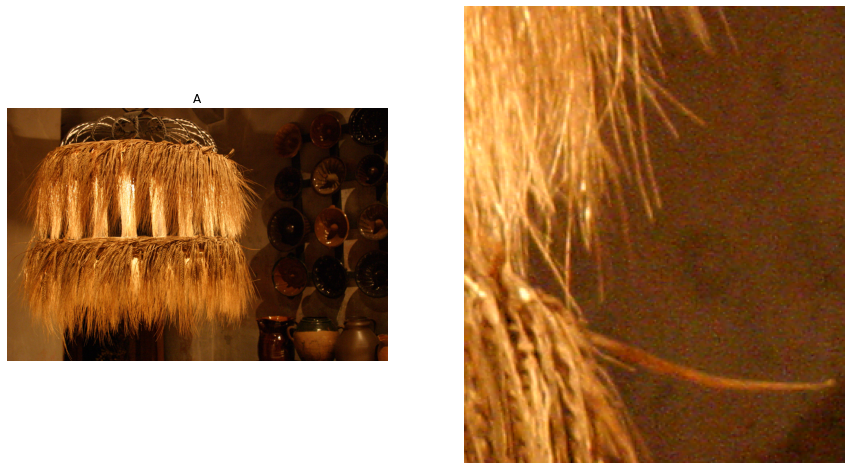

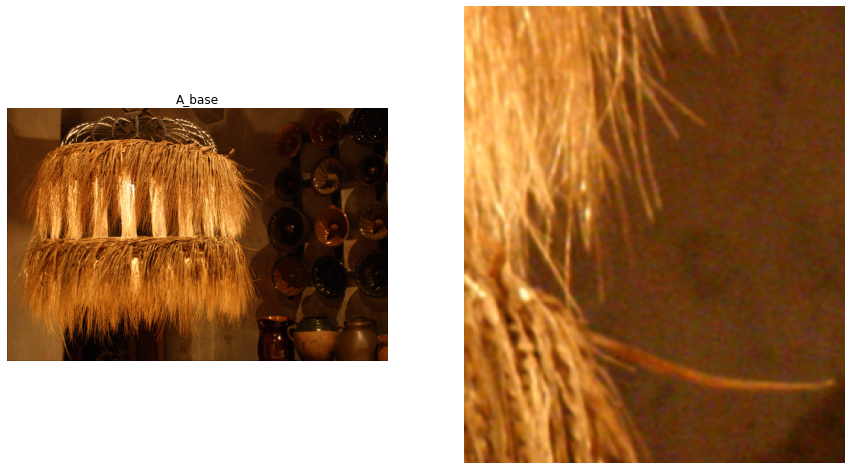

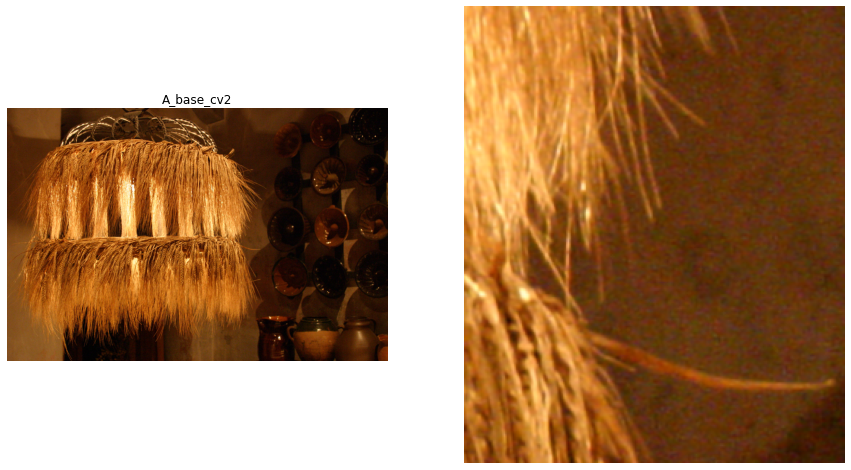

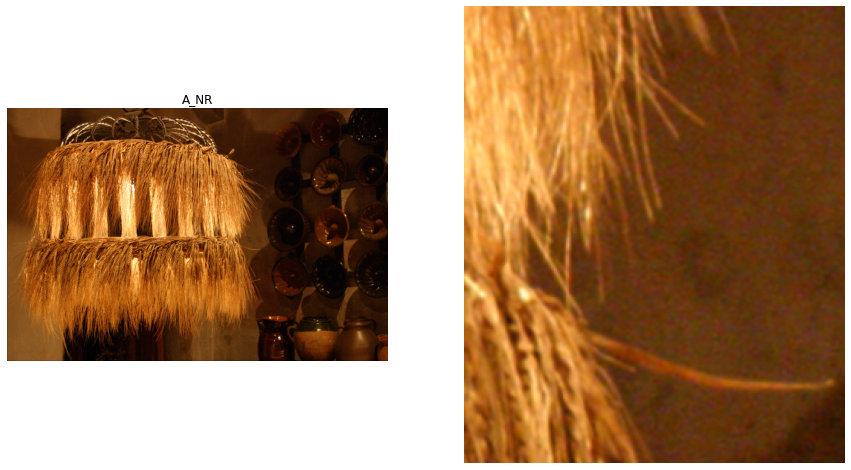

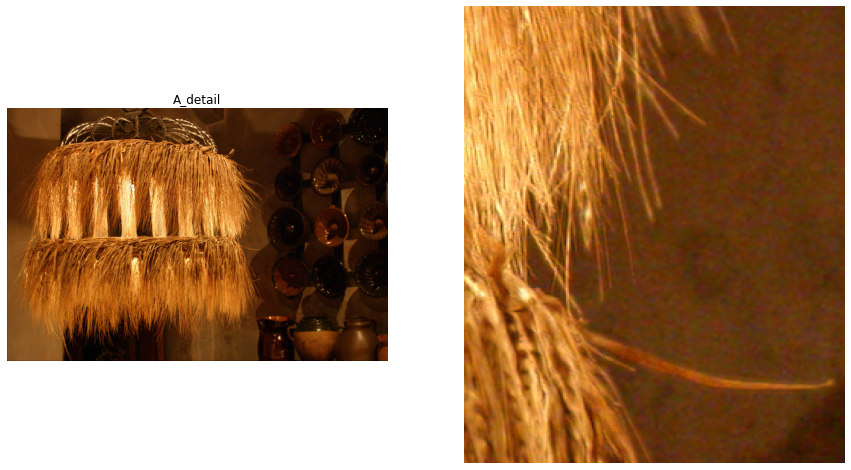

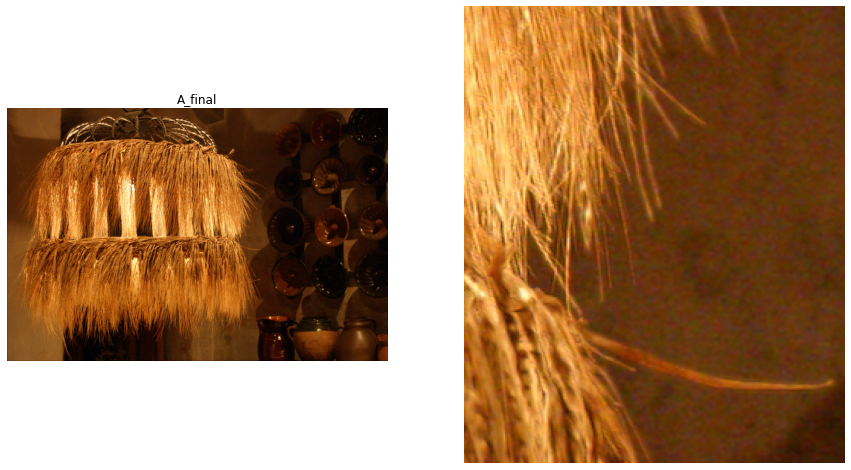

In [369]:
plot_img(A,'A',1800,2050,900,1200)    
plot_img(A_base,'A_base',1800,2050,900,1200) 
plot_img(A_base_cv2,'A_base_cv2',1800,2050,900,1200) 
plot_img(A_NR,'A_NR',1800,2050,900,1200) 
plot_img(A_detail,'A_detail',1800,2050,900,1200) 
plot_img(A_final,'A_final',1800,2050,900,1200)